**Pre-trained Convolutional Neural Networks**

Import TensorFlow

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow==2.0.0

import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
keras = tf.keras

     |████████████████████████████████| 380.8MB 42kB/s 
     |████████████████████████████████| 3.8MB 39.6MB/s 
     |████████████████████████████████| 450kB 71.3MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exist

     |████████████████████████████████| 86.3MB 86kB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


Load the dataset using tfds package

In [0]:
import pandas as pd

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
SPLIT_WEIGHT = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHT)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


Downloading and preparing cats_vs_dogs datasets

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Show the first two images and labels from the training set

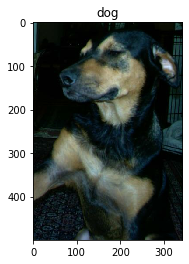

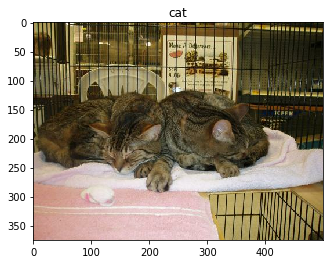

In [6]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

Format the data

Resize the image to a fix input size, and rescale the input channels to a range of [-1, -1]

In [0]:
IMG_SIZE = 160 # All the images will be resize to 160*160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Now shuffle and batch the data

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data

In [11]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

Create a base model from the pre-trained convnets

Creating a base model from the **MobileNet v2** model developed at Google

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Creating the base model from MobileNet V2 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [37]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

This feature extractor converts each 160x160x3 to 5x5x1280 block of features

In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


**Feature Extraction**

We freeze the convolutional base as a feature extractor, and create a classifier on top of it and then train the top-level classifier.


**Freeze the convolution base**

Freeze the base_model (weights) using layer.trainable=False. MobileNetV2 has many layers so set entire model's trainable flag to False.

In [15]:
base_model.trainable=False

# Lets take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Add a classification head

To generate predictions from a block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply tf.keras.layers.Dense layer to convert these features into a single predictions per image

In [17]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a tf.keras.Sequential() model

In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

Compile the model

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
len(model.trainable_variables)

2

Train the Model

After training for 10 epochs, we should see ~96% Accuracy

In [0]:
num_train, num_val, num_test = (
    metadata.splits['train'].num_examples*weight/10
    for weight in SPLIT_WEIGHT
)

In [23]:
initial_epochs = 10
steps_per_epochs = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 21s 1s/step - loss: 6.7433 - accuracy: 0.4313


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 6.74
initial accuracy: 0.43


In [25]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 1032s 2s/step - loss: 4.0894 - accuracy: 0.5739 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 944s 2s/step - loss: 1.3441 - accuracy: 0.8203 - val_loss: 0.6387 - val_accuracy: 0.9086
Epoch 3/10
582/582 [==============================] - 907s 2s/step - loss: 0.8357 - accuracy: 0.8886 - val_loss: 0.5046 - val_accuracy: 0.9349
Epoch 4/10
582/582 [==============================] - 882s 2s/step - loss: 0.7242 - accuracy: 0.9032 - val_loss: 0.4643 - val_accuracy: 0.9414
Epoch 5/10
582/582 [==============================] - 877s 2s/step - loss: 0.5759 - accuracy: 0.9193 - val_loss: 0.4225 - val_accuracy: 0.9496
Epoch 6/10
582/582 [==============================] - 868s 1s/step - loss: 0.5571 - accuracy: 0.9257 - val_loss: 0.3990 - val_accuracy: 0.9565
Epoch 7/10
582/582 [==============================] - 912s 2s/step - loss: 0.5167 - accuracy: 0.9310 - val_loss: 0.3930 - val_accurac

Learning Curves

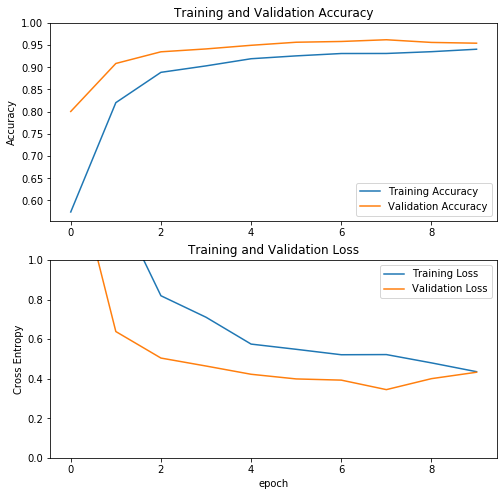

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Un-freeze the top layers of the model

In [0]:
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine Tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  155


Compile the model

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [60]:
len(model.trainable_variables)

2

Continue Train the model

In [58]:
fine_tune_epochs = 2
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=validation_batches)

Epoch 11/12
582/582 [==============================] - 1010s 2s/step - loss: 0.4402 - accuracy: 0.9421 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/12
582/582 [==============================] - 975s 2s/step - loss: 0.4628 - accuracy: 0.9398 - val_loss: 0.4051 - val_accuracy: 0.9569


Let's look at the learning curve

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

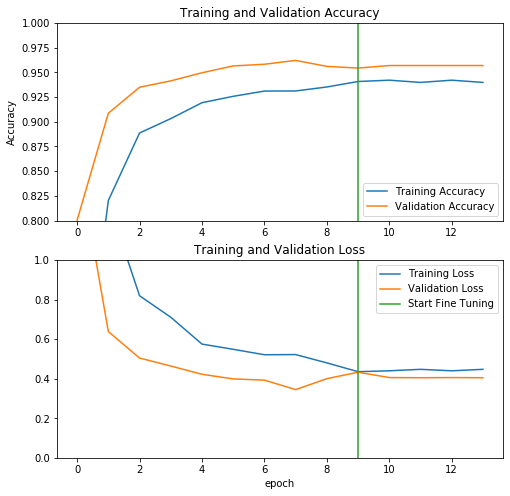

In [63]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Conclusion